In [1]:
import cvxpy as cp
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import os
import pandas as pd
import plotly.express as px
import random

from sodapy import Socrata

pd.set_option("display.max_columns", 1000)

(CVXPY) Nov 26 11:31:08 AM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/kimsha/anaconda3/envs/ev-load-forecast-nyc/lib/python3.10/site-packages/_scs_direct.cpython-310-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: <EA245032-41C7-30EA-BA1A-C55492696949> /Users/kimsha/anaconda3/envs/ev-load-forecast-nyc/lib/python3.10/site-packages/_scs_direct.cpython-310-darwin.so\n  Reason: tried: '/Users/kimsha/anaconda3/envs/ev-load-forecast-nyc/lib/python3.10/site-packages/../../liblapack.3.dylib' (no such file), '/Users/kimsha/anaconda3/envs/ev-load-forecast-nyc/lib/python3.10/site-packages/../../liblapack.3.dylib' (no such file), '/Users/kimsha/anaconda3/envs/ev-load-forecast-nyc/bin/../lib/liblapack.3.dylib' (no such file), '/Users/kimsha/anaconda3/envs/ev-load-forecast-nyc/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in d

# Matrix Completion: Chelsea

## Data Collection

### GeoJSON Data

In [2]:
# Get shaply value from geojson
polygon = gpd.read_file('chelsea_network.geojson').to_crs(4326)['geometry'][0]

# Create graph from Open Street Map based on graph, Include travel time over edges
G = ox.add_edge_travel_times(ox.add_edge_speeds(ox.graph_from_polygon(polygon, network_type='drive', simplify=True)))

## The current method of just using osmnx to get the lines is not granular enough so we need to refilter the graph with gpd
# Creates dataframes based on nodes and edges
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

# Remove edges outside of polygon
edges_gdf = edges_gdf[edges_gdf.geometry.within(polygon) == True]

<Axes: >

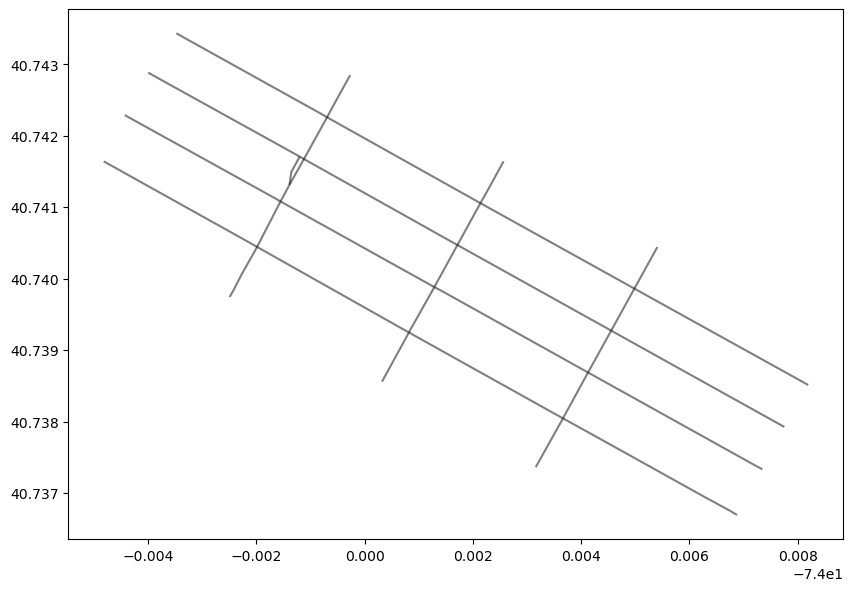

In [3]:
fig, ax = plt.subplots(figsize=(10,10))
edges_gdf.plot(ax=ax, color='black', alpha=0.5)

### ATR Data

In [4]:
APP_TOKEN = os.getenv('APP_TOKEN')
client = Socrata('data.cityofnewyork.us', APP_TOKEN)
def request_atr_series(ids):
    endpoint = "7ym2-wayt"

    query = "SELECT COUNT(*)"

    NUM_RECORDS = int(client.get(endpoint, query=query)[0]['COUNT'])
    
    query = f"""
        SELECT *
        WHERE segmentid IN ({', '.join(map(str, ids))})
        AND yr = 2019
        LIMIT {NUM_RECORDS}
    """
    
    df = pd.DataFrame.from_records(client.get(endpoint, query=query))

    df['ts'] = pd.to_datetime(df[['yr', 'm', 'd', 'hh', 'mm']]\
                 .apply(lambda row: '-'.join(row), axis=1), format='%Y-%m-%d-%H-%M')
    df = df.astype({'vol':float})   
    
    
    gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df.wktgeom, crs="ESRI:102718")).drop(columns=['wktgeom'])
    gdf = gdf.to_crs(4326)
    
    gdf['segment_direction'] = df.segmentid + '-' + df.direction
    
    return gdf

atrs_gdf = request_atr_series([32462, 32285,
                         32467, 32814,
                         32811, 32798, 32795,
                         32628, 32634, 32632,
                         32460, 32458, 271225,
                         32299, 32301, 32463])

## Joining Data

In [5]:
# match our ATR data (df) to the closest street segment in the OSMNX graph (gdf_edges)
atrs_with_streets_gdf = atrs_gdf.to_crs(3857).sjoin_nearest(
    edges_gdf.reset_index().to_crs(3857), distance_col='dist', how='inner'
).drop(columns=['index_right']).to_crs(4326).rename(columns={'geometry':'atr_geometry'}).set_geometry('atr_geometry')

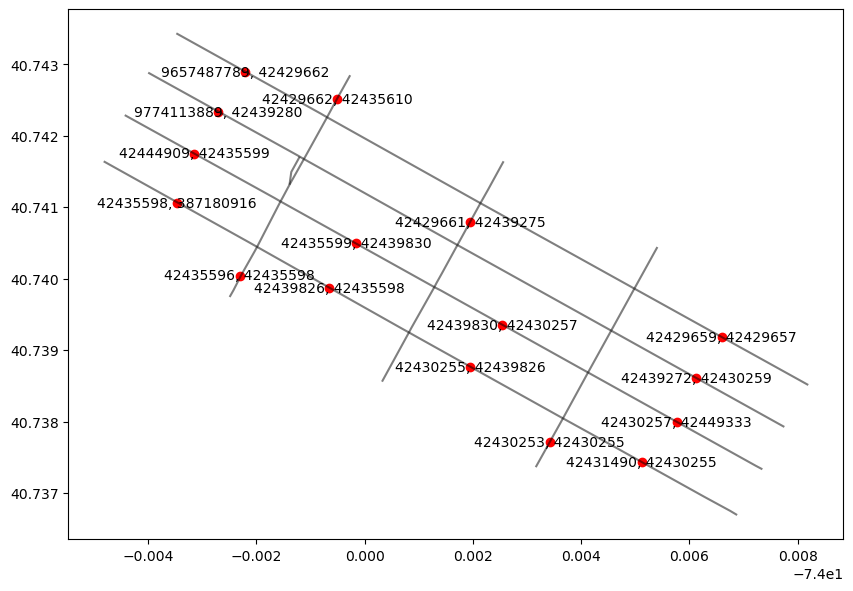

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
edges_gdf.plot(ax=ax, color='black', alpha=0.5)
unique_atr_gdf = atrs_with_streets_gdf.dissolve(by=['u','v','key'], as_index=False)
unique_atr_gdf.plot(ax=ax, color='red')

for idx, row in unique_atr_gdf.iterrows():
    plt.annotate(text= str(row['u']) + ', ' + str(row['v']), xy=row['atr_geometry'].coords[0], horizontalalignment='center',
                 verticalalignment='center')

## Graph Simplification

Due to computational constraints, we're going to simplify this network into a set of source / sink edges, and a primary "central" edge which contains all of the parking capacity contained within the core network

In [7]:
inbound_atrs_lst = {
    '14st_8av': ('42435596','42435598'),
    '16st_8av':('42444909','42435599'),
    '18st_8av':('9657487789','42429662'),
    '14st_6av':('42430253','42430255'),
    '15st_6av':('42431490','42430255'),
    '17st_6av':('42439272','42430259'),
    # NONE
    '19st_7av': ('19st_7av','inbound_central')
}
outbound_atrs_lst = {
    '15st_8av':('42435598','387180916'),
    '17st_8av':('9774113889','42439280'),
    '19st_8av':('42429662','42435610'),
    '18st_6av':('42429659','42429657'),
    '16st_6av':('42430257','42449333'),
    # NONE
    '14st_7av':('outbound_central','14st_7av'), 
    '19st_6av':('outbound_central','19st_6av')
}

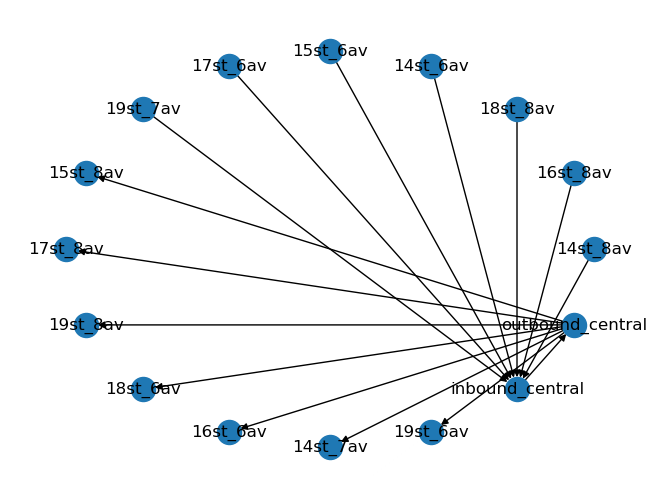

In [8]:
G = nx.DiGraph()

G.add_nodes_from(inbound_atrs_lst.keys())

G.add_nodes_from(outbound_atrs_lst.keys())

G.add_nodes_from(['inbound_central','outbound_central'])


for key, value in inbound_atrs_lst.items():
    G.add_edge(key, 'inbound_central', uv = value)
    
for key, value in outbound_atrs_lst.items():
    G.add_edge('outbound_central', key, uv = value)

G.add_edge('inbound_central', 'outbound_central')

# Track primal graph
G_prime=nx.line_graph(G)

# temporarily sufficient way to visualize the directed graph - spring layout looks wack
nx.draw_circular(G, with_labels=True)


In [9]:
all_source_sink = {v: k for k, v in nx.get_edge_attributes(G, 'uv').items()}

## Transform Flow

dataframe with a row for each edge. columns is time stamps

In [10]:
# Let's work with the window with least missingness for now
window = '1D'
chosen_date = atrs_with_streets_gdf.groupby(pd.Grouper(key='ts', freq=window)).size().idxmax().date()
chosen_date

datetime.date(2019, 10, 20)

In [11]:
# Combine u, v (origin-destination) IDs
flow_df = atrs_with_streets_gdf[atrs_with_streets_gdf.ts.dt.date == chosen_date].copy()
flow_df['u,v'] = flow_df.apply(lambda x: (str(x['u']), str(x['v'])), axis = 1)

In [12]:
# Unstack and filter u, v to ATRs included in the simplified graph
flow_df = flow_df.pivot(columns = 'ts', index = 'u,v', values = 'vol')
flow_df = flow_df[flow_df.index.isin(all_source_sink.keys())]
# map to labels created for the networkx graph
flow_df.index = flow_df.index.map(all_source_sink)

In [13]:
# Add in edges that are completely missing ATR data
flow_df = pd.concat([
    flow_df, pd.DataFrame(index=list(set(G.edges) - set(flow_df.index)), columns=flow_df.columns)
]).sort_index()

/var/folders/42/qlm4zcmj6jb69bb7c3htqswc0000gn/T/ipykernel_18109/406651154.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  flow_df = pd.concat([


## CVXPY
Minimize $$||\bar{\Omega} \odot (\bar{F} - \bar{F_c})||_F^2 + ||\Omega \odot (F - F_c)||_F^2 + \lambda_1||\bar{F}L'F||_F + \lambda_2||FL'\bar{F}||_F + \lambda_3||\bar{F}(:, t+1) - \bar{F}(:, t)||_F + \lambda_4||F(:, t+1) - F(:, t)||_F + \lambda_5||\bar{F} - F||_F$$
s.t.
1. $F_c, \bar{F_c} > 0$
2. $F_c, \bar{F_c}$ contain integer elements
3. $P(t+1) = P(t) + \bar{F}(t) - F(t)$

In [14]:
# We're going to treat all ATR flows as outflows from that particular edge
# Hence, F_in is entirely NaN (which we fill with -1)
F_out = flow_df.fillna(-1).to_numpy()
F_in = np.zeros_like(F_out)
F_in[:, :] = -1

F_in.shape

(15, 96)

In [15]:
# Completed versions of F_in and F_out matrices, respectively.
F_in_c = cp.Variable(F_in.shape, integer=True)
F_out_c = cp.Variable(F_out.shape, integer=True)

In [16]:
# Net parking state matrix at time 0 (i.e., initial number of parked cars)
P0 = np.zeros((F_in.shape[0], 1))

In [17]:
# Omegas are binary matrices (with the same dimensions as F_in and F_out, respectively) where each element indicates whether the corresponding element in F_in / F_out is known (1) or unknown (0).
def indicator_function(arr):
    indicator_arr = np.zeros_like(arr)
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if arr[i, j] != -1:
                indicator_arr[i, j] = 1
            else:
                indicator_arr[i, j] = 0
    return indicator_arr


omega_in = indicator_function(F_in)
omega_out = indicator_function(F_out)

# Regularization parameters that controls the trade-off between fitting the known elements and promoting a low-rank structure.
l1, l2, l3, l4, l5 = 1, 1, 1, 1, 1

$$||\bar{\Omega} \odot (\bar{F} - \bar{F_c})||_F^2 + ||\Omega \odot (F - F_c)||_F^2$$

In [18]:
expr1 = cp.square(cp.atoms.norm(cp.multiply(omega_in, (F_in - F_in_c)), p='fro'))
expr2 = cp.square(cp.atoms.norm(cp.multiply(omega_out, (F_out - F_out_c)), p='fro'))

$$\lambda_1||\bar{F}^\intercal L'F||_F + \lambda_2||F^\intercal L'\bar{F}||_F$$

In [19]:
# Network prime graph
L_prime = nx.directed_laplacian_matrix(G_prime, nodelist=list(flow_df.index))

expr3 = l1 * cp.atoms.norm(F_in.T @ L_prime @ F_out, p='fro')
expr4 = l2 * cp.atoms.norm(F_out.T @ L_prime @ F_in, p='fro')

$$\lambda_3||\bar{F}(:, t+1) - \bar{F}(:, t)||_F + \lambda_4||F(:, t+1) - F(:, t)||_F$$

In [20]:
expr5 = l3 * cp.atoms.norm(F_in[:, 1:] - F_in[:, :-1], p='fro')
expr6 = l4 * cp.atoms.norm(F_out[:, 1:] - F_out[:, :-1], p='fro')

$$\lambda_5||\bar{F} - F||_F$$

In [21]:
expr7 = l5 * cp.atoms.norm(F_in - F_out, p='fro')

1. $F_c, \bar{F_c} > 0$
2. $F_c, \bar{F_c}$ contain integer elements
3. $P(t+1) = P(t) + \bar{F}(t) - F(t)$

In [22]:
# Define the constraints
constraints = [
    F_in_c >= 0,  # Ensure each element of F_in_c is positive
    F_out_c >= 0,  # Ensure each element of F_out_c is positive
    # assert for Parking matrix to be positive
    P0 + cp.cumsum(F_in_c - F_out_c, axis=1) >= 0
]

**Run Model**

In [23]:
problem = cp.Problem(objective=cp.Minimize(expr1 + expr2 + expr3 + expr4 + expr5 + expr6 + expr7),
                     constraints=constraints)

problem.solve(solver=cp.GUROBI, reoptimize=False)
problem.status

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-10


'optimal'

In [24]:
F_in_c.value

array([[ 424., 1369.,   -0., ...,  292.,  302.,  278.],
       [ 244.,   -0.,   -0., ...,   22.,   25.,   26.],
       [ 181.,   -0.,   -0., ...,   12.,   17.,    6.],
       ...,
       [ 380.,   -0.,   -0., ...,   23.,   31.,   14.],
       [  -0.,   -0.,    0., ...,    0.,    0.,    0.],
       [ 266.,  634.,   -0., ...,  136.,  142.,  119.]])

In [25]:
F_out_c.value

array([[424., 450., 488., ..., 292., 302., 278.],
       [ 76.,  62.,  48., ...,  22.,  25.,  26.],
       [ 54.,  63.,  64., ...,  12.,  17.,   6.],
       ...,
       [ 84.,  94., 122., ...,  23.,  31.,  14.],
       [ -0.,   0.,  -0., ...,  -0.,  -0.,  -0.],
       [266., 294., 340., ..., 136., 142., 119.]])